In [1]:
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.transforms import v2
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt
from helpers import plot
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchinfo import summary
import numpy as np
from deep_image_prior.models import get_net

In [2]:
img_size = (512, 512)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transforms = v2.Compose(
    [
        v2.Resize(img_size),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize(mean=[0.5], std=[0.5]),
    ]
)
img = read_image("data/F16_GT.png")
img = transforms(img)

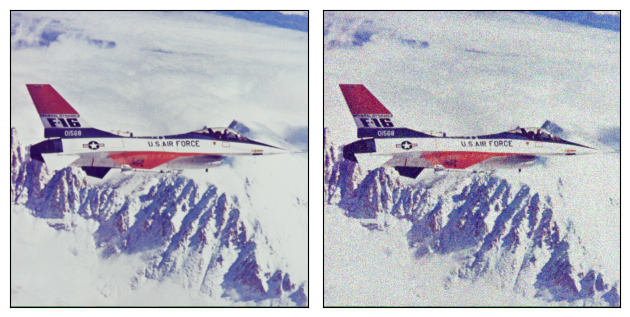

In [3]:
def get_noisy_image(img, sigma):
    return torch.clip(img + torch.normal(0.0, sigma, size=img.shape), 0, 1).detach()


sigma = 25
sigma_ = sigma / 255.0
noisy_img = get_noisy_image(img, sigma_)

plot([img, noisy_img])

In [4]:
def generate_noise(noise_type, shape: tuple[int]):
    if noise_type == "normal":
        return torch.randn(shape)
    elif noise_type == "uniform":
        return (
            torch.FloatTensor(*shape).uniform_(0, 1) * 1.0 / 10
        )  # dip paper use 0 ~ 0.1 with input range 0 ~ 1
    else:
        raise ValueError("Invalid noise type")


model_input = generate_noise("uniform", (1, 32, *img_size)).detach()

In [5]:
input_depth = 32
pad = "reflection"
model = get_net(
    input_depth,
    "skip",
    pad,
    skip_n33d=128,
    skip_n33u=128,
    skip_n11=4,
    num_scales=5,
    upsample_mode="bilinear",
)
print(summary(model, input_data=model_input))

Layer (type:depth-idx)                                                                                    Output Shape              Param #
Sequential                                                                                                [1, 3, 512, 512]          --
├─Concat: 1-1                                                                                             [1, 132, 512, 512]        --
│    └─Sequential: 2-1                                                                                    [1, 4, 512, 512]          --
│    │    └─Sequential: 3-1                                                                               [1, 4, 512, 512]          132
│    │    └─BatchNorm2d: 3-2                                                                              [1, 4, 512, 512]          8
│    │    └─LeakyReLU: 3-3                                                                                [1, 4, 512, 512]          --
│    └─Sequential: 2-2                            

In [6]:
mse = nn.MSELoss()
# lr = 2e-4
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
reg_noise_std = 1.0 / 30.0
exp_weight = 0.99

In [7]:
model = model.to(device)
model_input = model_input.to(device)

noisy_img_np = noisy_img.clone().detach().cpu().numpy()
img_np = img.clone().detach().cpu().numpy()


noisy_img_torch = noisy_img.clone().detach().to(device).unsqueeze(0)
model_input_saved = model_input.detach().clone()
noise = model_input.detach().clone()

psrn_history = []
psrn_gt_history = []

ssim_history = []
ssim_gt_history = []

In [8]:
print("model_input shape:", model_input.shape)
print("noisy_img_np shape:", noisy_img_np.shape)
print("img_np shape:", img_np.shape)

print("noisy_img_torch shape:", noisy_img_torch.shape)
print("model_input_saved shape:", model_input_saved.shape)
print("noise shape:", noise.shape)

model_input shape: torch.Size([1, 32, 512, 512])
noisy_img_np shape: (3, 512, 512)
img_np shape: (3, 512, 512)
noisy_img_torch shape: torch.Size([1, 3, 512, 512])
model_input_saved shape: torch.Size([1, 32, 512, 512])
noise shape: torch.Size([1, 32, 512, 512])


  0%|          | 0/2000 [00:00<?, ?it/s]

Loss: 0.09242629259824753, PSNR: 10.342044741650065, PSNR_GT: 10.764409673185337, SSIM: 0.033100660890340805, SSIM_GT: 0.19524814188480377


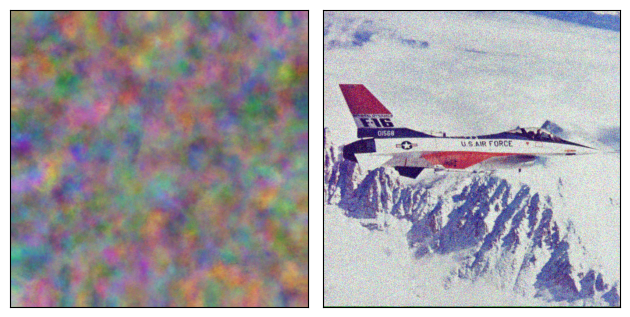

Loss: 0.01463385485112667, PSNR: 18.346412900026433, PSNR_GT: 22.547800705300403, SSIM: 0.13392610847949982, SSIM_GT: 0.660525381565094


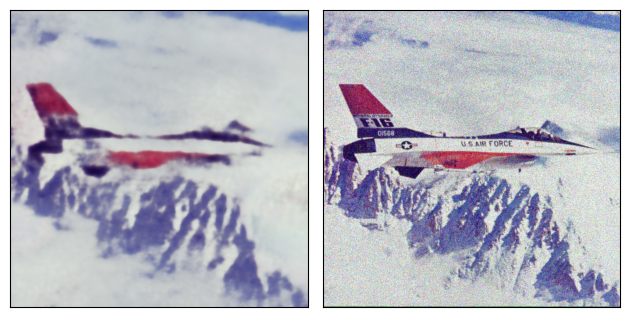

Loss: 0.012379447929561138, PSNR: 19.072987327246928, PSNR_GT: 24.77212760849307, SSIM: 0.17110782861709595, SSIM_GT: 0.7198300957679749


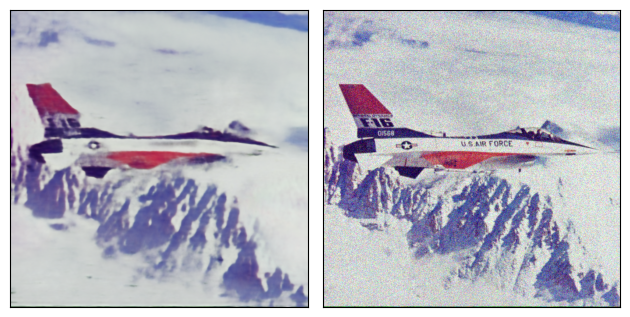

Loss: 0.011506540700793266, PSNR: 19.39055230728371, PSNR_GT: 26.04301098601426, SSIM: 0.1909351944923401, SSIM_GT: 0.7499616742134094


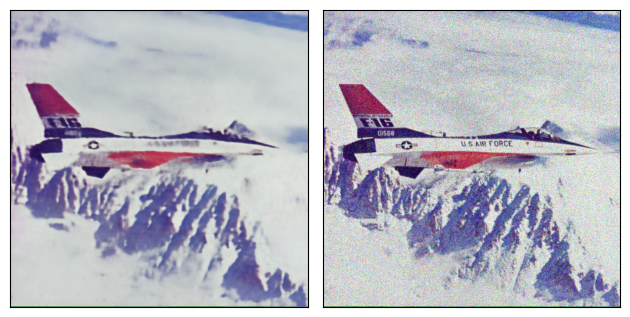

Loss: 0.01083835493773222, PSNR: 19.650366515989163, PSNR_GT: 27.376201208668792, SSIM: 0.20759379863739014, SSIM_GT: 0.7819746136665344


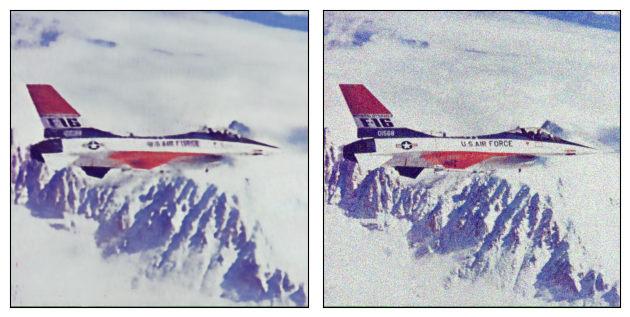

Loss: 0.01048712246119976, PSNR: 19.79343680404799, PSNR_GT: 28.205376200171454, SSIM: 0.22018176317214966, SSIM_GT: 0.8031653761863708


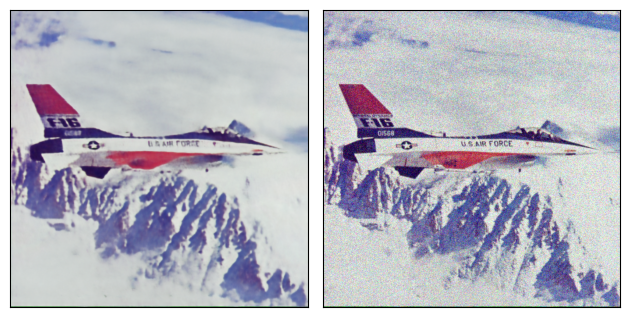

Loss: 0.010246964171528816, PSNR: 19.894048097298842, PSNR_GT: 28.858800971396708, SSIM: 0.22917503118515015, SSIM_GT: 0.8163528442382812


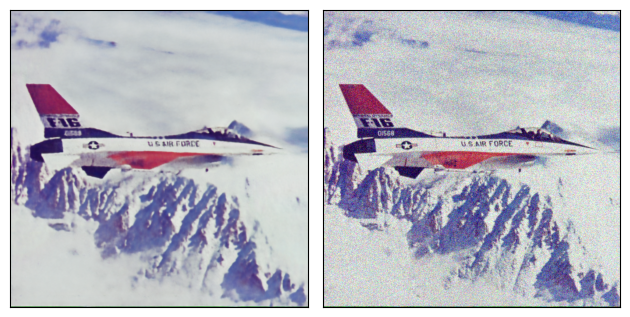

Loss: 0.010052076540887356, PSNR: 19.977442420222616, PSNR_GT: 29.322690569545603, SSIM: 0.23887379467487335, SSIM_GT: 0.8275575041770935


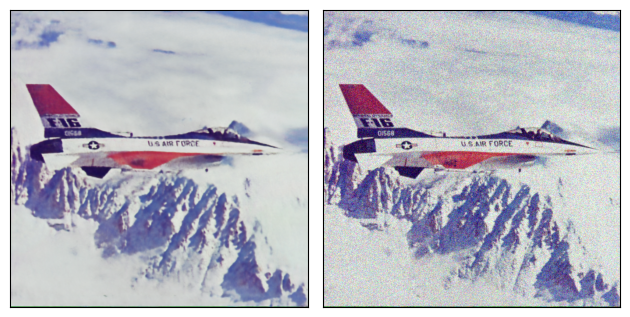

Loss: 0.00990680605173111, PSNR: 20.0406633591445, PSNR_GT: 29.6725053001212, SSIM: 0.24384798109531403, SSIM_GT: 0.8309515118598938


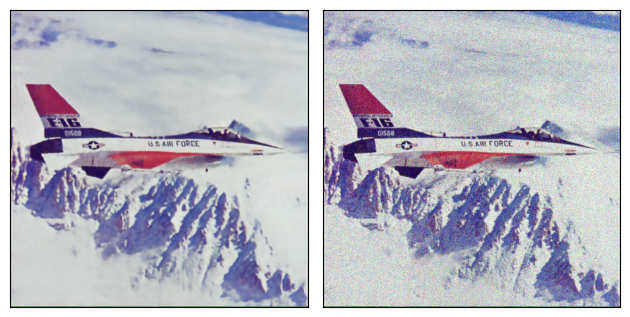

Loss: 0.009790054522454739, PSNR: 20.092149124008138, PSNR_GT: 29.941648913468754, SSIM: 0.2497718781232834, SSIM_GT: 0.8348212838172913


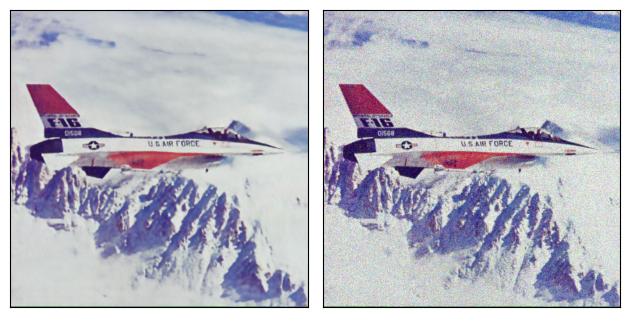

In [9]:
iteration = 2000
for i in (pbar := tqdm(range(iteration))):
    optimizer.zero_grad()
    model_input = model_input_saved + (noise.normal_() * reg_noise_std)

    out = model(model_input)

    loss = mse(out, noisy_img_torch)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        out_np = out.detach().cpu().numpy()[0]

        psrn = peak_signal_noise_ratio(noisy_img_np, out_np)
        psrn_gt = peak_signal_noise_ratio(img_np, out_np)

        ssim = structural_similarity(
            noisy_img_np, out_np, data_range=out_np.max() - out_np.min(), channel_axis=0
        )
        ssim_gt = structural_similarity(
            img_np, out_np, data_range=out_np.max() - out_np.min(), channel_axis=0
        )

        psrn_history.append(psrn)
        psrn_gt_history.append(psrn_gt)

        ssim_history.append(ssim)
        ssim_gt_history.append(ssim_gt)

        pbar.set_postfix(
            {
                "Loss": round(loss.item(), 6),
                "PSNR": round(psrn, 2),
                "PSNR_GT": round(psrn_gt, 2),
                "SSIM": round(ssim, 2),
                "SSIM_GT": round(ssim_gt, 2),
            }
        )
    if i % 200 == 0:
        print(
            f"Loss: {loss.item()}, PSNR: {psrn}, PSNR_GT: {psrn_gt}, SSIM: {ssim}, SSIM_GT: {ssim_gt}"
        )
        plot([out.squeeze(0), noisy_img.squeeze(0)])

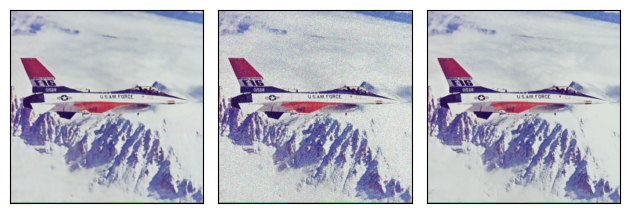

Final PSNR: 30.346603875007855, Final SSIM: 0.835683286190033


In [10]:
out = model(model_input)
plot([out.squeeze(0), noisy_img.squeeze(0), img])
psrn_final = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
ssim_final = structural_similarity(
    img_np, out.detach().cpu().numpy()[0], data_range=out_np.max() - out_np.min(), channel_axis=0
)
print(f"Final PSNR: {psrn_final}, Final SSIM: {ssim_final}")

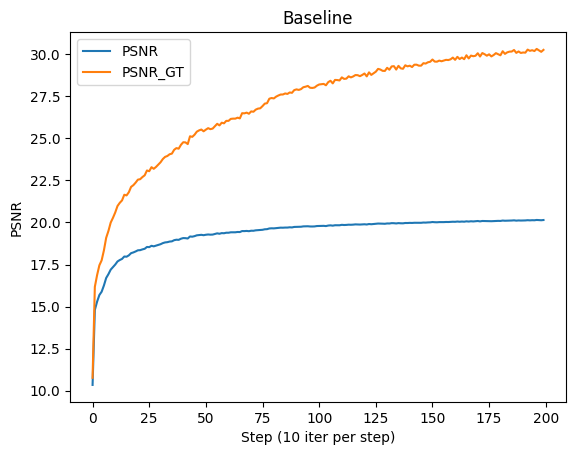

In [11]:
plt.plot(psrn_history, label="PSNR")
plt.plot(psrn_gt_history, label="PSNR_GT")
plt.xlabel("Step (10 iter per step)")
plt.ylabel("PSNR")
plt.title("Baseline")
plt.legend()

In [12]:
max_psnr = max(psrn_gt_history)
max_psnr_idx = psrn_gt_history.index(max_psnr)
print(f"Max PSNR: {max_psnr}, at step {max_psnr_idx}")

Max PSNR: 30.320465409695455, at step 196


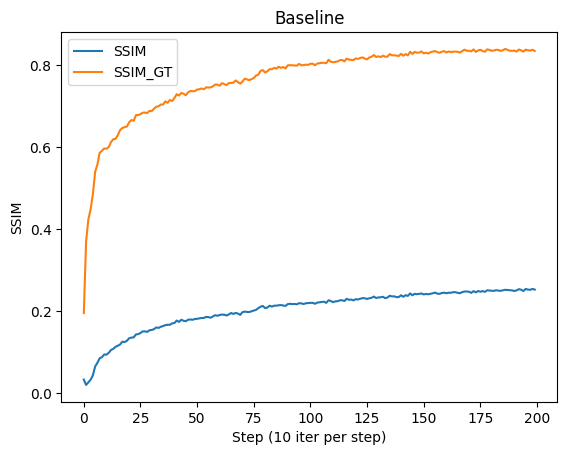

In [13]:
plt.plot(ssim_history, label="SSIM")
plt.plot(ssim_gt_history, label="SSIM_GT")
plt.xlabel("Step (10 iter per step)")
plt.ylabel("SSIM")
plt.title("Baseline")
plt.legend()

In [14]:
max_ssim = max(ssim_gt_history)
max_ssim_idx = ssim_gt_history.index(max_ssim)
print(f"Max SSIM: {max_ssim}, at step {max_ssim_idx}")

Max SSIM: 0.8395193219184875, at step 186


In [15]:
np.save("results/baseline_psnr.npy", np.array(psrn_history))
np.save("results/baseline_psnr_gt.npy", np.array(psrn_gt_history))

np.save("results/baseline_ssim.npy", np.array(ssim_history))
np.save("results/baseline_ssim_gt.npy", np.array(ssim_gt_history))